In [32]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from shapely.geometry import Point
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [2]:
# DOH Restaurant Inspections
params_restaurants = {
    '$where': "inspection_date between '2018-01-01T00:00:00' and '2023-12-31T23:59:59' AND latitude > 0.1",
    '$limit': 500000  # Limit the number of records, adjust as needed
}
restaurants_url = 'https://data.cityofnewyork.us/resource/43nn-pn8j.geojson'
# https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j


In [3]:
# Load restaurant inspections

restuarant_response = requests.get(restaurants_url, params=params_restaurants)
restuarant_json = restuarant_response.json()
restuarant_gdf = gpd.GeoDataFrame.from_features(restuarant_json['features'])
print(len(restuarant_gdf))
restuarant_gdf.head()

193294


geometry   nta zipcode         latitude             dba violation_code  \
0     None  QN51   11354  40.767270137751  HANEUL BABSANG            09B   
1     None  MN40   10028  40.775412817718           MAMAN           None   
2     None  BK90   11206  40.705232327599         19 CAFE           None   
3     None  QN70   11106  40.762659334839  TAMASHII RAMEN            09B   
4     None  BX08   10472  40.831329469463         FU XING           None   

  score cuisine_description         bbl building         longitude  \
0    28              Korean  4052360127    15129  -73.812772032045   
1     0          Coffee/Tea  1015090039     1424  -73.956478321047   
2  None          Coffee/Tea  3030790001       84  -73.944593208116   
3    25            Japanese  4005880007     2905  -73.926838859608   
4     0             Chinese  2037780028     1270  -73.875030657296   

           inspection_date               grade_date grade  \
0  2022-12-27T00:00:00.000                     None  None   
1  2022-08-23T00:00:00.000  2022-08-23T00:00:00.000     A   
2  2023-01-05T00:00:00.000                     None  None   
3  2022-04-07T00:00:00.000                     None  None   
4  2022-05-17T00:00:00.000  2022-05-17T00:00:00.000     Z   

          violation_description                          inspection_type  \
0   Thawing procedure improper.    Cycle Inspection / Initial Inspection   
1                          None         Cycle Inspection / Re-inspection   
2                          None           Trans Fat / Initial Inspection   
3  Thawing procedures improper.    Cycle Inspection / Initial Inspection   
4                          None  Cycle Inspection / Reopening Inspection   

  census_tract       boro      bin            street community_board  \
0       115500     Queens  4118306          34TH AVE             407   
1       014000  Manhattan  1047526          3 AVENUE             108   
2       050500   Brooklyn  3071330  MANHATTAN AVENUE             301   
3       007500     Queens  4007472          BROADWAY             401   
4       006200      Bronx  2025386   MORRISON AVENUE             209   

               record_date   critical_flag  \
0  2023-04-21T06:00:09.000    Not Critical   
1  2023-04-21T06:00:09.000  Not Applicable   
2  2023-04-21T06:00:10.000  Not Applicable   
3  2023-04-21T06:00:09.000    Not Critical   
4  2023-04-21T06:00:09.000  Not Applicable   

                                              action       phone  \
0    Violations were cited in the following area(s).  7184450243   
1  No violations were recorded at the time of thi...  6464767660   
2  No violations were recorded at the time of thi...  7183878777   
3    Violations were cited in the following area(s).  7182785888   
4                  Establishment re-opened by DOHMH.  9298556668   

  council_district     camis  
0               20  50033695  
1               05  50110709  
2               34  50015841  
3               22  50000249  
4               18  50084872

In [4]:
restuarant_gdf.critical_flag.value_counts()

Critical          107120
Not Critical       83955
Not Applicable      2219
Name: critical_flag, dtype: int64

In [8]:
restuarant_gdf.action.value_counts()

Violations were cited in the following area(s).                                                                                       183097
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.      7373
Establishment re-opened by DOHMH.                                                                                                       1812
No violations were recorded at the time of this inspection.                                                                             1008
Establishment re-closed by DOHMH.                                                                                                          4
Name: action, dtype: int64

In [71]:
# Filters

# Only include the critical 
pest_control_df = restuarant_gdf[restuarant_gdf['critical_flag'] == 'Critical']
print(len(pest_control_df))

# Only keep violations related to mice/rats, flies, roaches 
pest_control_codes = ['04K', '04L', '04M', '04N']
pest_control_df = pest_control_df[pest_control_df['violation_code'].isin(pest_control_codes)]
print(len(pest_control_df))

# Remove the re-opened and no violations 
remove_actions = ['Establishment re-opened by DOHMH.',
                  'No violations were recorded at the time of this inspection.']
pest_control_df = pest_control_df[~(pest_control_df['action'].isin(remove_actions))]

pest_control_df.head(2)

107120
29287


geometry   nta zipcode         latitude          dba violation_code score  \
36     None  QN52   11355  40.750578335059  SATAY HOUSE            04M    23   
46     None  QN22   11354  40.760330552591  ALOHA SUSHI            04M     0   

   cuisine_description         bbl building         longitude  \
36  Asian/Asian Fusion  4052080001     4601  -73.819063069054   
46            Japanese  4049787501    13617   -73.82987293105   

            inspection_date               grade_date grade  \
36  2022-07-26T00:00:00.000                     None  None   
46  2022-09-12T00:00:00.000  2022-09-12T00:00:00.000     A   

                                violation_description  \
36  Live roaches in facility's food or non-food area.   
46  Live roaches in facility's food or non-food area.   

                             inspection_type census_tract    boro      bin  \
36     Cycle Inspection / Initial Inspection       120500  Queens  4117599   
46  Pre-permit (Operational) / Re-inspection       087100  Queens  4534816   

          street community_board              record_date critical_flag  \
36  KISSENA BLVD             407  2023-04-21T06:00:09.000      Critical   
46      39TH AVE             407  2023-04-21T06:00:09.000      Critical   

                                             action       phone  \
36  Violations were cited in the following area(s).  7188881868   
46  Violations were cited in the following area(s).  9292943581   

   council_district     camis  
36               20  50093495  
46               20  50106059

In [72]:
pest_control_df.action.value_counts()

Violations were cited in the following area(s).                                                                                       27204
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.     1683
Name: action, dtype: int64

In [73]:
pest_control_df.violation_description.value_counts()

Evidence of mice or live mice present in facility's food and/or non-food areas.                                                                                                                                                                                                                        8116
Evidence of mice or live mice in establishment's food or non-food areas.                                                                                                                                                                                                                               5406
Filth flies or food/refuse/sewage-associated (FRSA) flies present in facility’s food and/or non-food areas.  Filth flies include house flies, little house flies, blow flies, bottle flies and flesh flies.  Food/refuse/sewage-associated flies include fruit flies, drain flies and Phorid flies.    5260
Filth flies or food/refuse/sewage associated with (FRSA) flies or other nuisance pests  in  establis

In [74]:
top_cuisines = pest_control_df.cuisine_description.value_counts().nlargest(10).index.to_list()
pest_control_df['cuisine_group'] = np.where(pest_control_df.cuisine_description.isin(top_cuisines), pest_control_df.cuisine_description, 'other')
pest_control_df.cuisine_group.value_counts()

other                       10817
American                     4574
Chinese                      3095
Pizza                        1916
Coffee/Tea                   1419
Caribbean                    1346
Latin American               1219
Mexican                      1199
Bakery Products/Desserts     1195
Italian                      1135
Japanese                      972
Name: cuisine_group, dtype: int64

In [75]:
# Create a function to simplify location type

def simplify_violation(violation_description):
    
    if 'rats' in violation_description or 'mice' in violation_description:
        return "rats/mice"

    if 'roaches' in violation_description:
        return "roaches"

    if 'flies' in violation_description:
        return "flies"
    
    print(violation_description) # Unhandled groups
       
pest_control_df['violation_group'] = pest_control_df.apply(lambda row: simplify_violation(row['violation_description']), axis=1)
                      
pest_control_df.violation_group.value_counts()


rats/mice    15595
flies         9156
roaches       4136
Name: violation_group, dtype: int64

In [76]:
# Add year to the violation 

def create_date_cols(df):
    df['inspection_date'] = pd.to_datetime(df['inspection_date'])

    # Create new columns for month, day of the week, and hour of the day
    df['year'] = df['inspection_date'].dt.strftime('%Y')  # Year as a string
    return df

pest_control_df = create_date_cols(pest_control_df)
pest_control_df.year.value_counts()

2022    13718
2023     4467
2019     4316
2021     3813
2020     2061
2018      512
Name: year, dtype: int64

In [77]:
# Convert the data to a geodataframe
relevant_inspection_fields = ['latitude','longitude', 'year', 'violation_group','cuisine_group']

# Convert latitude and longitude to numeric types
pest_control_df['latitude'] = pd.to_numeric(pest_control_df['latitude'], errors='coerce')
pest_control_df['longitude'] = pd.to_numeric(pest_control_df['longitude'], errors='coerce')

# Create the geometry column
geometry = [Point(xy) for xy in zip(pest_control_df.longitude, pest_control_df.latitude)]

# Create the geodataframe
pest_control_gdf = gpd.GeoDataFrame(pest_control_df[relevant_inspection_fields], geometry=geometry)

# Drop the latitude and longitude columns
pest_control_gdf = pest_control_gdf.drop(['latitude', 'longitude'], axis=1)

pest_control_gdf.head()

year violation_group cuisine_group                    geometry
36  2022         roaches         other  POINT (-73.81906 40.75058)
46  2022         roaches      Japanese  POINT (-73.82987 40.76033)
57  2023         roaches    Coffee/Tea  POINT (-73.92950 40.69373)
65  2022         roaches       Italian  POINT (-73.95052 40.65961)
87  2023       rats/mice       Chinese  POINT (-73.99717 40.71515)

<AxesSubplot:>

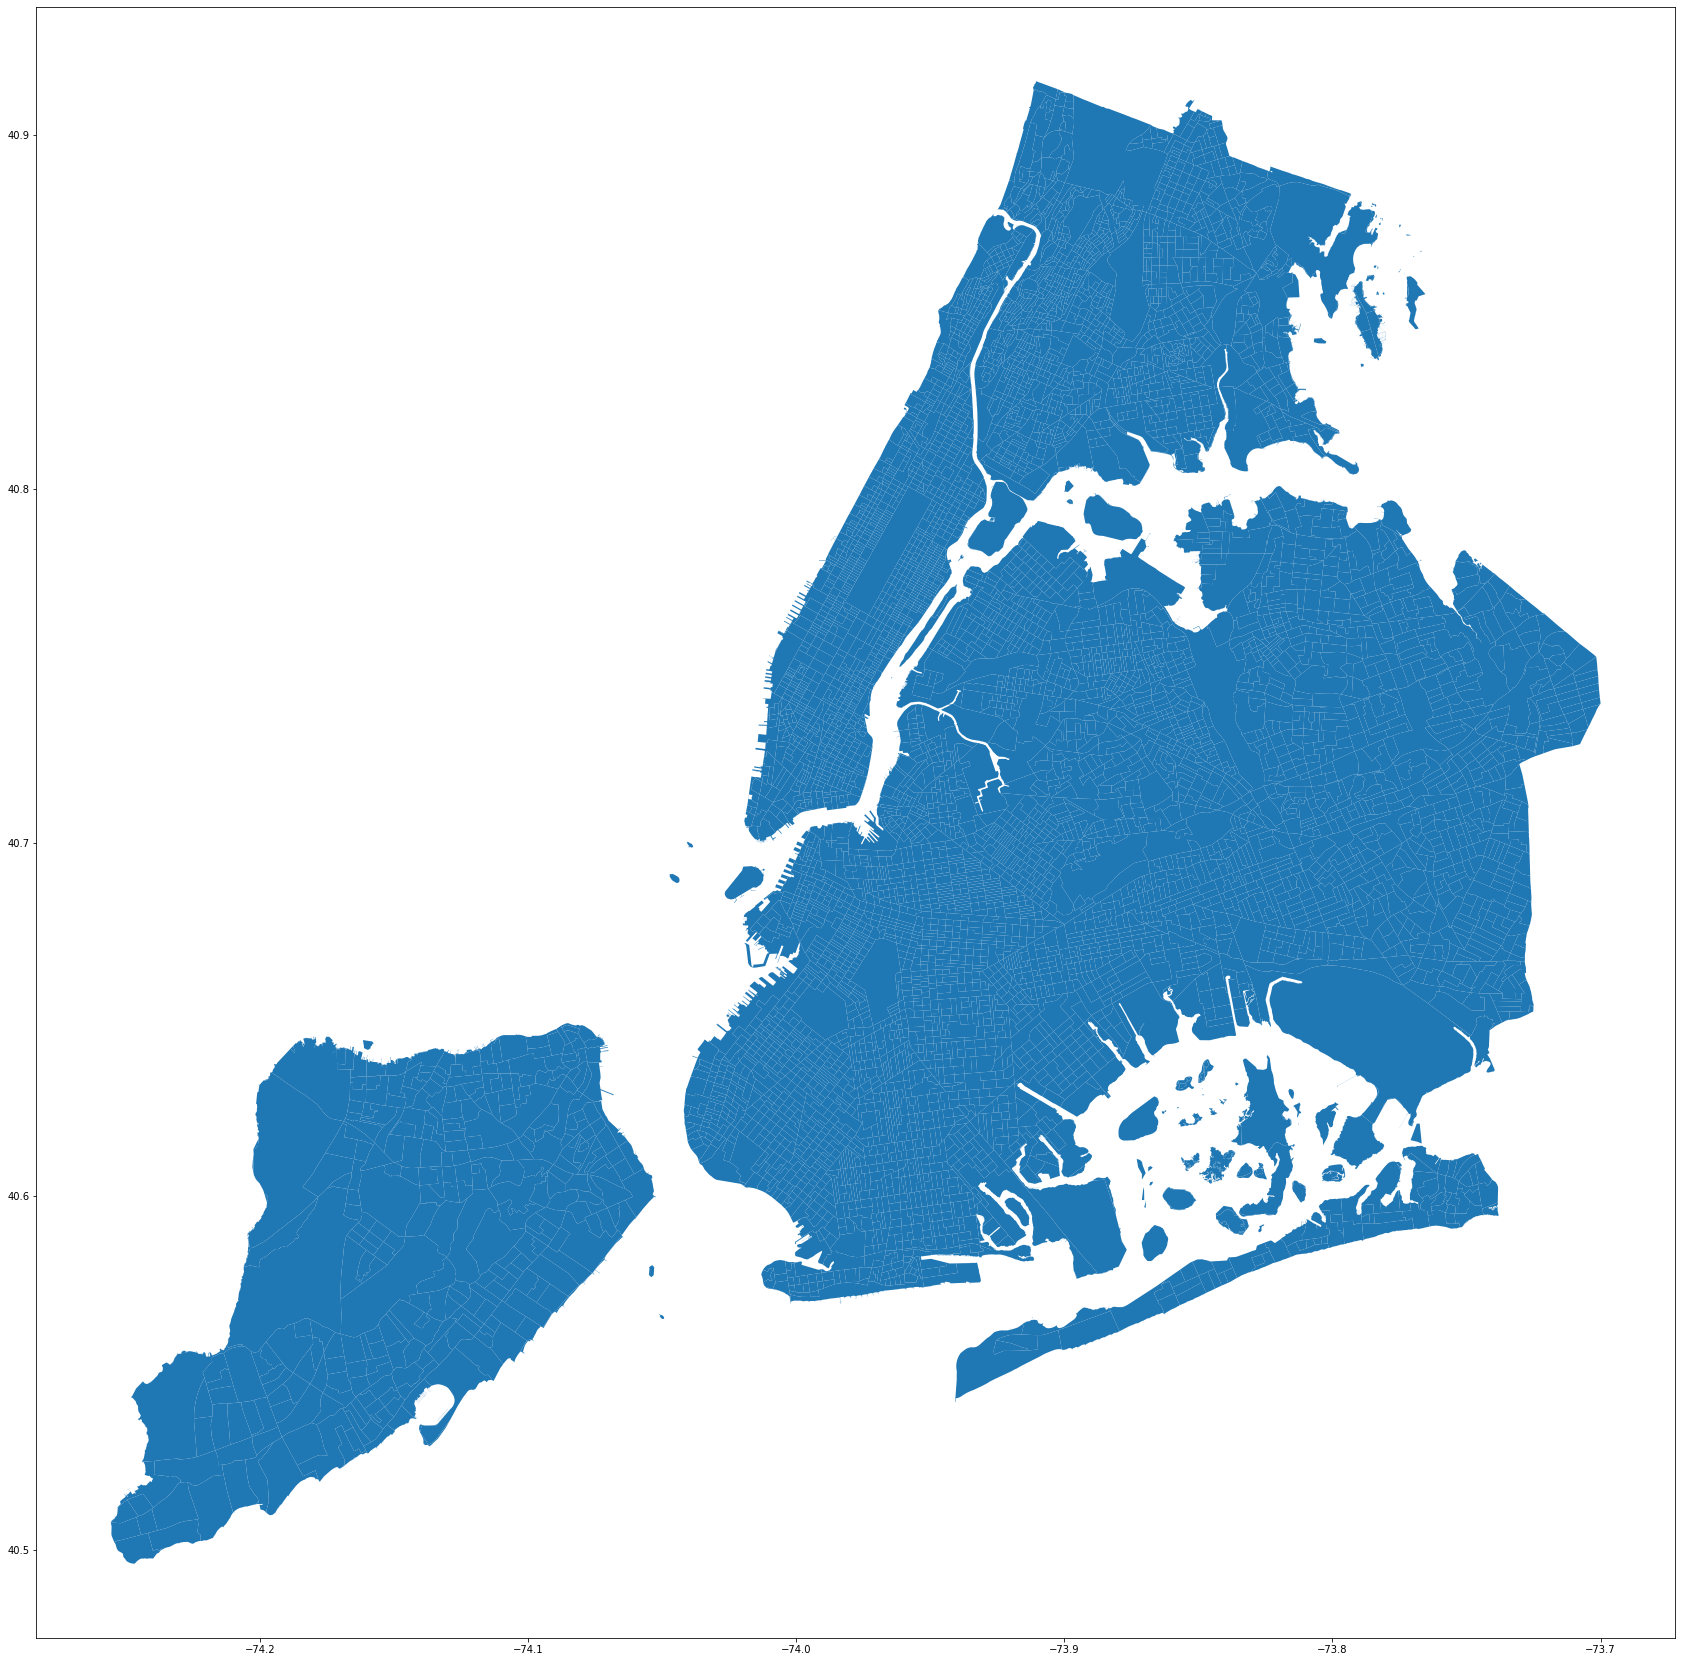

In [78]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
cb_gdf.plot(figsize=(30,30))

In [79]:
# One hot encode the variables to columns

violations_encoded = pd.get_dummies(pest_control_gdf['violation_group'], prefix='v')
cuisines_encoded = pd.get_dummies(pest_control_gdf['cuisine_group'], prefix='c')
    
# Merge new variables
violations_merge = pd.merge(pest_control_gdf, violations_encoded, left_index=True, right_index=True)
violations_merge = pd.merge(violations_merge, cuisines_encoded, left_index=True, right_index=True)
pest_control_encoded_gdf = gpd.GeoDataFrame(violations_merge, geometry='geometry')

pest_control_encoded_gdf.head(5)

year violation_group cuisine_group                    geometry  v_flies  \
36  2022         roaches         other  POINT (-73.81906 40.75058)        0   
46  2022         roaches      Japanese  POINT (-73.82987 40.76033)        0   
57  2023         roaches    Coffee/Tea  POINT (-73.92950 40.69373)        0   
65  2022         roaches       Italian  POINT (-73.95052 40.65961)        0   
87  2023       rats/mice       Chinese  POINT (-73.99717 40.71515)        0   

    v_rats/mice  v_roaches  c_American  c_Bakery Products/Desserts  \
36            0          1           0                           0   
46            0          1           0                           0   
57            0          1           0                           0   
65            0          1           0                           0   
87            1          0           0                           0   

    c_Caribbean  c_Chinese  c_Coffee/Tea  c_Italian  c_Japanese  \
36            0          0             0          0           0   
46            0          0             0          0           1   
57            0          0             1          0           0   
65            0          0             0          1           0   
87            0          1             0          0           0   

    c_Latin American  c_Mexican  c_Pizza  c_other  
36                 0          0        0        1  
46                 0          0        0        0  
57                 0          0        0        0  
65                 0          0        0        0  
87                 0          0        0        0

In [82]:
# Perform spatial join
pest_control_joined_tracts_gdf = gpd.sjoin(pest_control_encoded_gdf, cb_gdf[['geometry','spatial_id']], op='within', how='left')

def aggregate_pest_control(df):
    # Aggregate the complaints
    inspection_columns = [col for col in df.columns if col.startswith('v_')] + [col for col in df.columns if col.startswith('c_')]
    inspection_agg_dict = {col: ['sum'] for col in inspection_columns}
    inspection_agg_dict['year'] = 'count'
    inspection_agg_df = df.groupby(['spatial_id','year']).agg(inspection_agg_dict).reset_index()
    inspection_agg_df.columns = inspection_agg_df.columns.map('_'.join)
    inspection_agg_df = inspection_agg_df.rename(columns={'year_count': 'num_violations',
                                                        'year_':'year',
                                                        'spatial_id_':'spatial_id'})
    return inspection_agg_df
    
pest_control_agg_df = aggregate_pest_control(pest_control_joined_tracts_gdf)
pest_control_agg_df.head()

spatial_id  year  v_flies_sum  v_rats/mice_sum  v_roaches_sum  \
0  360050004002  2019            0                0              1   
1  360050004002  2020            0                0              1   
2  360050004002  2022            1                0              0   
3  360050004002  2023            0                1              0   
4  360050019001  2019            1                0              0   

   c_American_sum  c_Bakery Products/Desserts_sum  c_Caribbean_sum  \
0               0                               0                0   
1               0                               0                0   
2               0                               0                0   
3               0                               0                0   
4               0                               0                0   

   c_Chinese_sum  c_Coffee/Tea_sum  c_Italian_sum  c_Japanese_sum  \
0              0                 0              0               0   
1              0                 0              0               0   
2              0                 0              0               0   
3              0                 0              0               0   
4              0                 0              0               1   

   c_Latin American_sum  c_Mexican_sum  c_Pizza_sum  c_other_sum  \
0                     0              0            0            1   
1                     0              0            0            1   
2                     0              0            0            1   
3                     1              0            0            0   
4                     0              0            0            0   

   num_violations  
0               1  
1               1  
2               1  
3               1  
4               1

In [83]:
# Duplicate the census blocks per years in dataset 
years = pest_control_agg_df.year.unique()

years_cb_gdf = pd.DataFrame() # empty dataframe

for year in years:
    year_cb_gdf = cb_gdf.copy()
    year_cb_gdf['year'] = year
    years_cb_gdf = pd.concat([years_cb_gdf, year_cb_gdf])

print(len(years_cb_gdf))

years_cb_gdf.head(5)


38958


spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2019  
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2019  
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2019  
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2019  
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2019

In [84]:
# Merge back to the census tracts 
pest_control_gdf = pd.merge(years_cb_gdf, pest_control_agg_df, on=['spatial_id','year'], how='left')

column_list = pest_control_gdf.columns[8:]
pest_control_gdf[column_list] = pest_control_gdf[column_list].fillna(0)
pest_control_gdf.head()

spatial_id                         name  %OfOwnerOccupiedHousing  \
0  360050001000  BG0001000, Bronx County, NY                   0.0000   
1  360050001001  BG0001001, Bronx County, NY                   0.0000   
2  360050002000  BG0002000, Bronx County, NY                   0.0000   
3  360050002001  BG0002001, Bronx County, NY                  48.0435   
4  360050002002  BG0002002, Bronx County, NY                  30.8962   

   %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
0                    0.0000                    NaN              0.0   
1                    0.0000                    NaN           6472.0   
2                    0.0000                    NaN              0.0   
3                   51.7391           40196.019522           1816.0   
4                   68.8679           47662.679687           1124.0   

                                            geometry  year  v_flies_sum  \
0  MULTIPOLYGON (((-73.89679 40.79616, -73.89681 ...  2019          0.0   
1  POLYGON ((-73.89076 40.79782, -73.89076 40.797...  2019          0.0   
2  MULTIPOLYGON (((-73.86163 40.80990, -73.86111 ...  2019          0.0   
3  POLYGON ((-73.86240 40.81491, -73.86148 40.815...  2019          0.0   
4  MULTIPOLYGON (((-73.86425 40.81466, -73.86333 ...  2019          0.0   

   v_rats/mice_sum  v_roaches_sum  c_American_sum  \
0              0.0            0.0             0.0   
1              0.0            0.0             0.0   
2              0.0            0.0             0.0   
3              0.0            0.0             0.0   
4              0.0            0.0             0.0   

   c_Bakery Products/Desserts_sum  c_Caribbean_sum  c_Chinese_sum  \
0                             0.0              0.0            0.0   
1                             0.0              0.0            0.0   
2                             0.0              0.0            0.0   
3                             0.0              0.0            0.0   
4                             0.0              0.0            0.0   

   c_Coffee/Tea_sum  c_Italian_sum  c_Japanese_sum  c_Latin American_sum  \
0               0.0            0.0             0.0                   0.0   
1               0.0            0.0             0.0                   0.0   
2               0.0            0.0             0.0                   0.0   
3               0.0            0.0             0.0                   0.0   
4               0.0            0.0             0.0                   0.0   

   c_Mexican_sum  c_Pizza_sum  c_other_sum  num_violations  
0            0.0          0.0          0.0             0.0  
1            0.0          0.0          0.0             0.0  
2            0.0          0.0          0.0             0.0  
3            0.0          0.0          0.0             0.0  
4            0.0          0.0          0.0             0.0

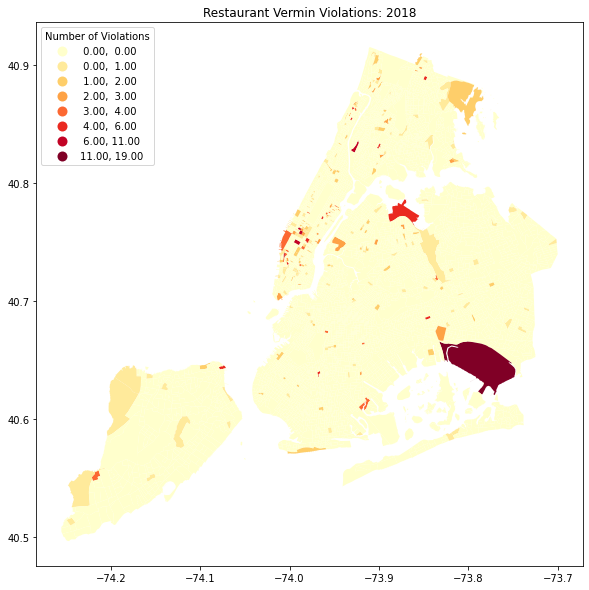

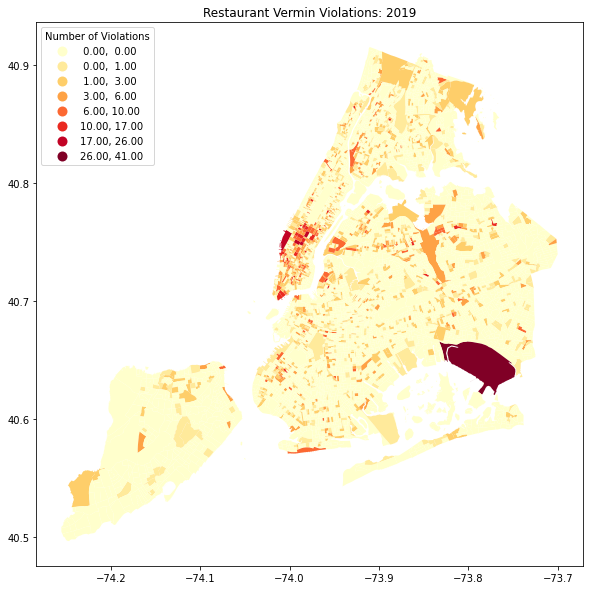

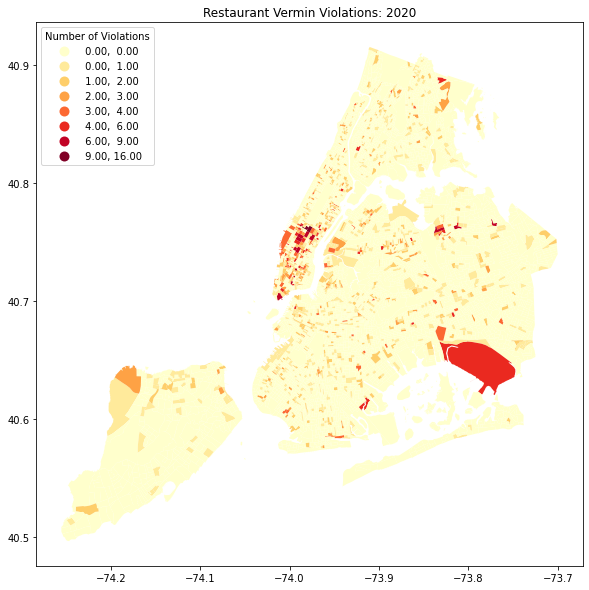

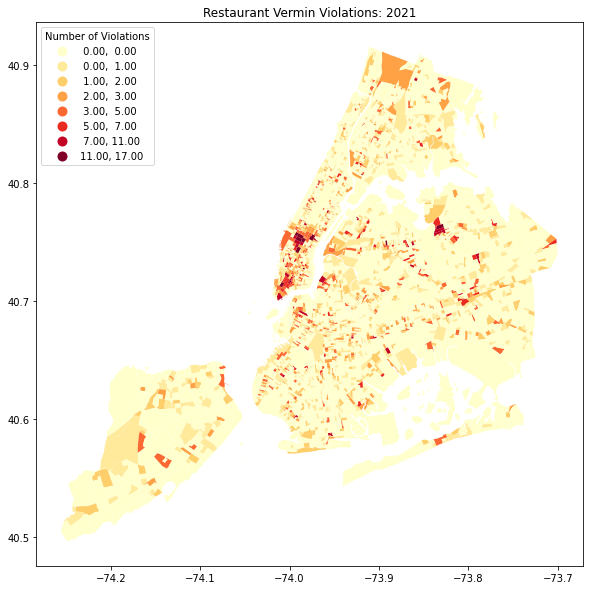

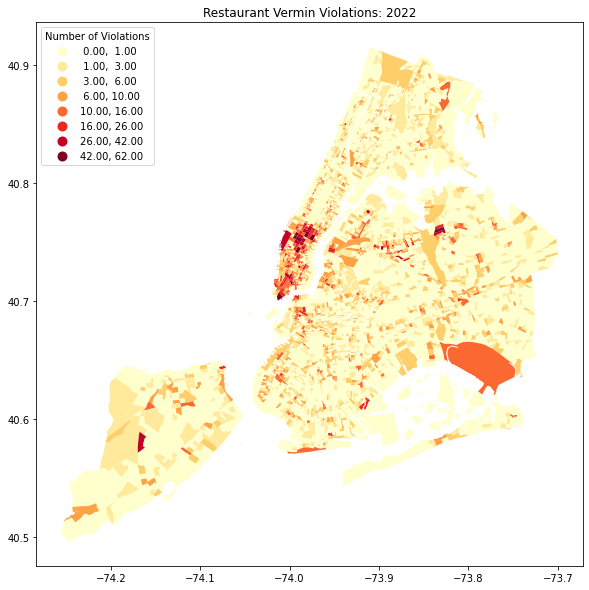

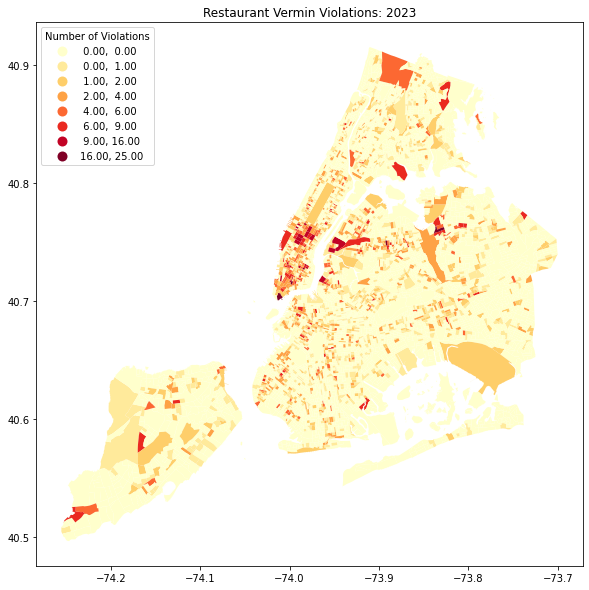

In [85]:
years = sorted(years)
for year in years:
    pest_control_annual_gdf = pest_control_gdf[(pest_control_gdf['year']==year)]
    # Natural Breaks (Jenks)
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    pest_control_annual_gdf.plot(column='num_violations',
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': 'Number of Violations'})
    plt.title('Restaurant Vermin Violations: {0}'.format(year))
    plt.show()

In [86]:
pest_control_slim_gdf = pest_control_gdf[(pest_control_gdf['year']=='2021')]
pest_control_slim_gdf.sort_values(by='num_violations', ascending=False).head(5)

spatial_id                            name  %OfOwnerOccupiedHousing  \
29570  360610092001  BG0092001, New York County, NY                  18.7371   
29633  360610113001  BG0113001, New York County, NY                  54.3478   
29317  360610032001  BG0032001, New York County, NY                   0.7407   
30897  360810289003    BG0289003, Queens County, NY                  42.8191   
26004  360050025001     BG0025001, Bronx County, NY                   4.6729   

       %OfRenterOccupiedHousing  MedianHouseholdIncome  TotalPopulation  \
29570                   81.1594          135872.411861           1403.0   
29633                   43.4783           99958.800000             87.0   
29317                   99.1770          116934.593413           1895.0   
30897                   57.0922           71200.184827           2969.0   
26004                   95.0156           33432.285714            857.0   

                                                geometry  year  v_flies_sum  \
29570  POLYGON ((-73.97743 40.75372, -73.97697 40.754...  2021          9.0   
29633  POLYGON ((-73.99073 40.75595, -73.99028 40.756...  2021         10.0   
29317  POLYGON ((-73.98488 40.72819, -73.98266 40.727...  2021          4.0   
30897  POLYGON ((-73.89212 40.75100, -73.89119 40.751...  2021          7.0   
26004  POLYGON ((-73.91922 40.80756, -73.91748 40.806...  2021          5.0   

       v_rats/mice_sum  v_roaches_sum  c_American_sum  \
29570              7.0            1.0             2.0   
29633              4.0            1.0             2.0   
29317             10.0            1.0             3.0   
30897              4.0            3.0             0.0   
26004              7.0            2.0             0.0   

       c_Bakery Products/Desserts_sum  c_Caribbean_sum  c_Chinese_sum  \
29570                             2.0              0.0            0.0   
29633                             0.0              0.0            1.0   
29317                             0.0              0.0            2.0   
30897                             0.0              0.0            1.0   
26004                             3.0              0.0            0.0   

       c_Coffee/Tea_sum  c_Italian_sum  c_Japanese_sum  c_Latin American_sum  \
29570               1.0            0.0             1.0                   0.0   
29633               2.0            1.0             1.0                   0.0   
29317               0.0            0.0             0.0                   2.0   
30897               0.0            0.0             0.0                   0.0   
26004               0.0            0.0             0.0                   0.0   

       c_Mexican_sum  c_Pizza_sum  c_other_sum  num_violations  
29570            0.0          4.0          7.0            17.0  
29633            2.0          2.0          4.0            15.0  
29317            0.0          1.0          7.0            15.0  
30897            0.0          0.0         13.0            14.0  
26004            2.0          5.0          4.0            14.0

In [88]:
export_columns = ['spatial_id'] + pest_control_gdf.columns[7:].to_list()
print(export_columns)
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'violations_per_year.csv')  # construct the file path
pest_control_gdf[export_columns].to_csv(file_path, index=False)

['spatial_id', 'year', 'v_flies_sum', 'v_rats/mice_sum', 'v_roaches_sum', 'c_American_sum', 'c_Bakery Products/Desserts_sum', 'c_Caribbean_sum', 'c_Chinese_sum', 'c_Coffee/Tea_sum', 'c_Italian_sum', 'c_Japanese_sum', 'c_Latin American_sum', 'c_Mexican_sum', 'c_Pizza_sum', 'c_other_sum', 'num_violations']


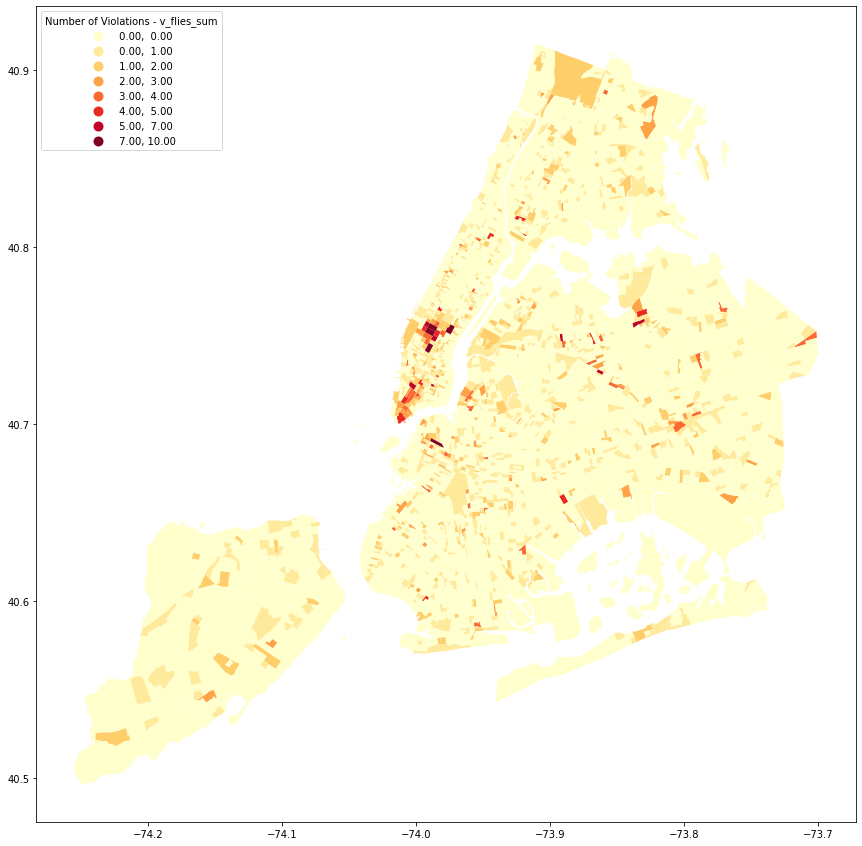

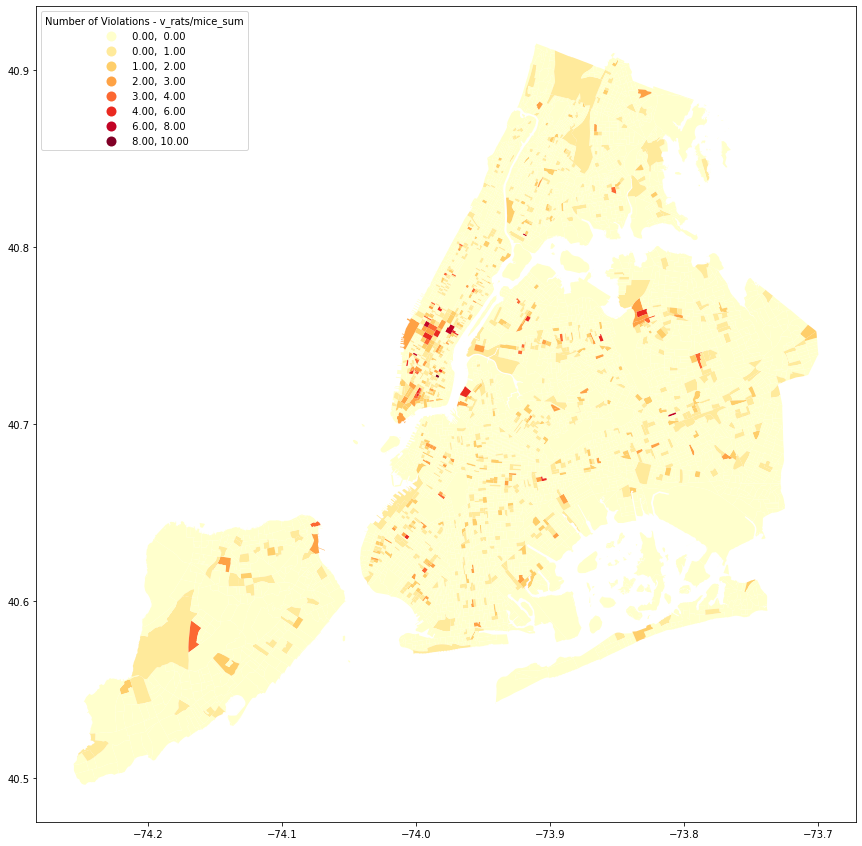

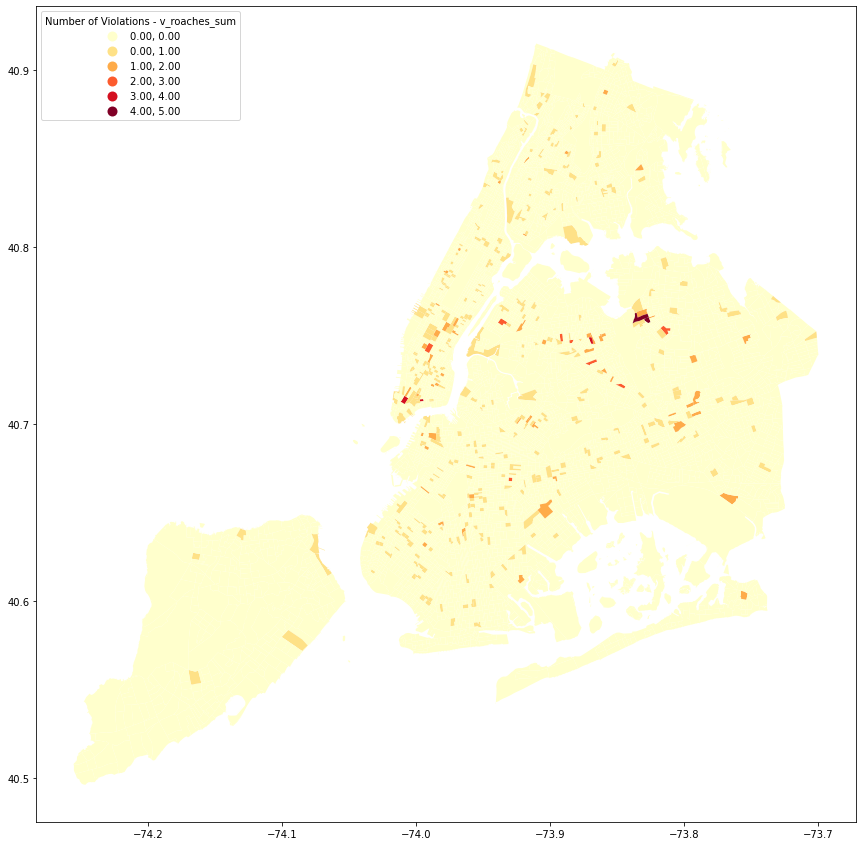

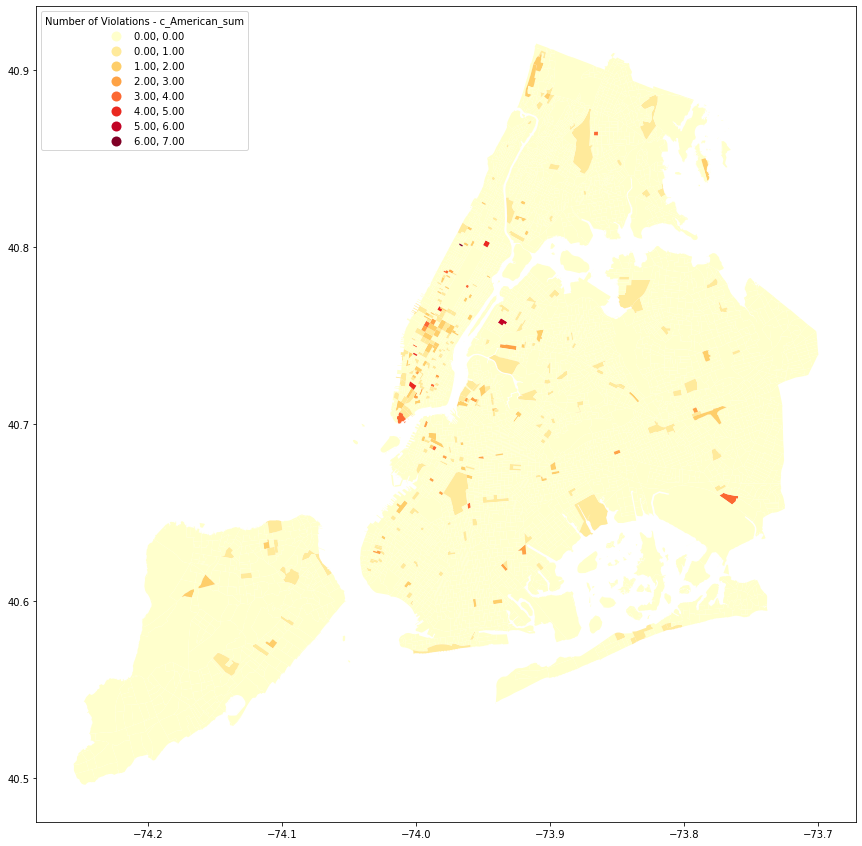

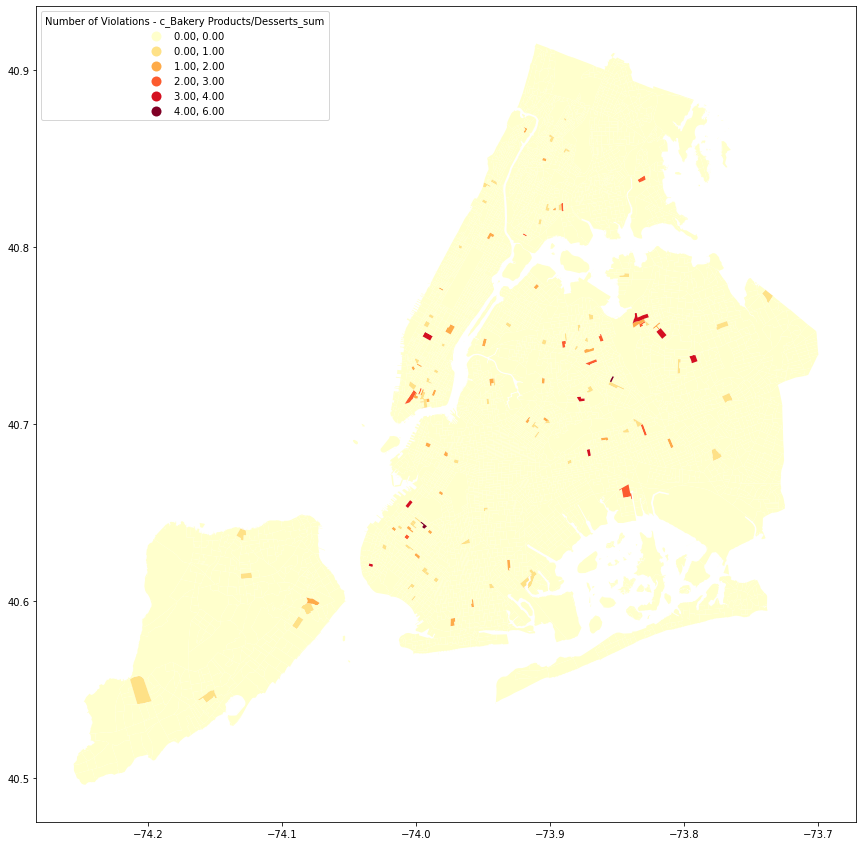

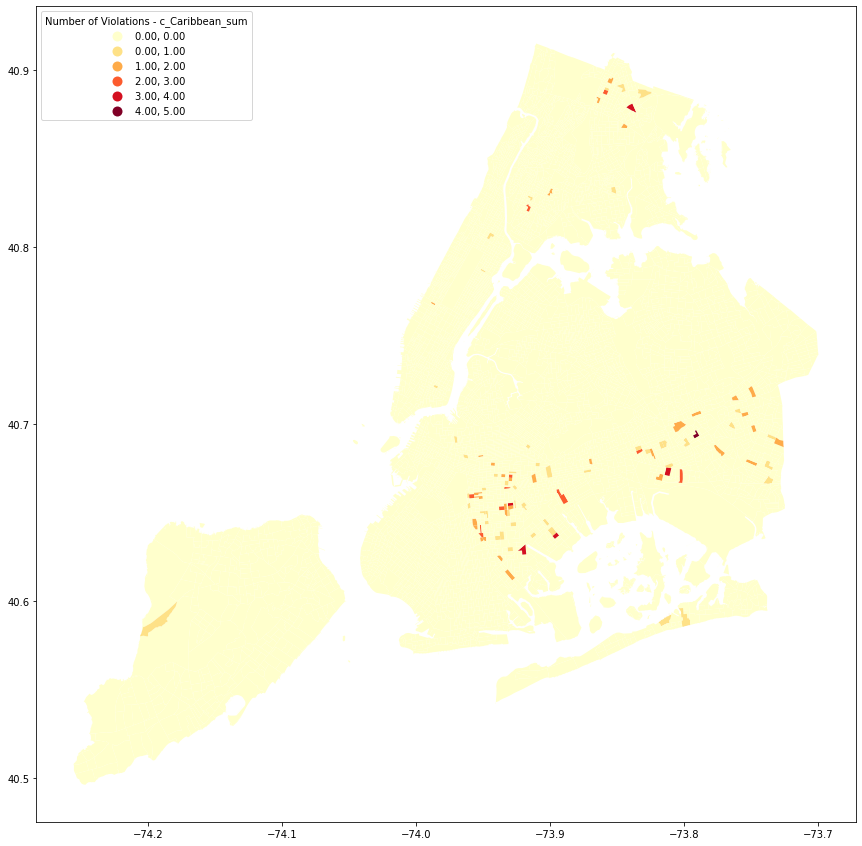

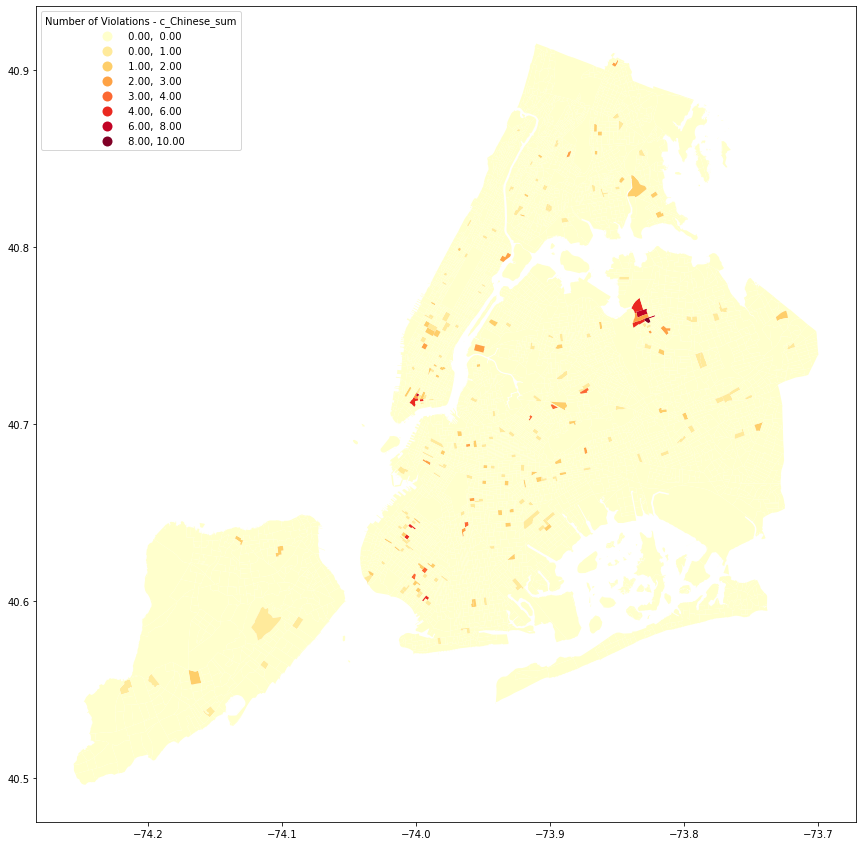

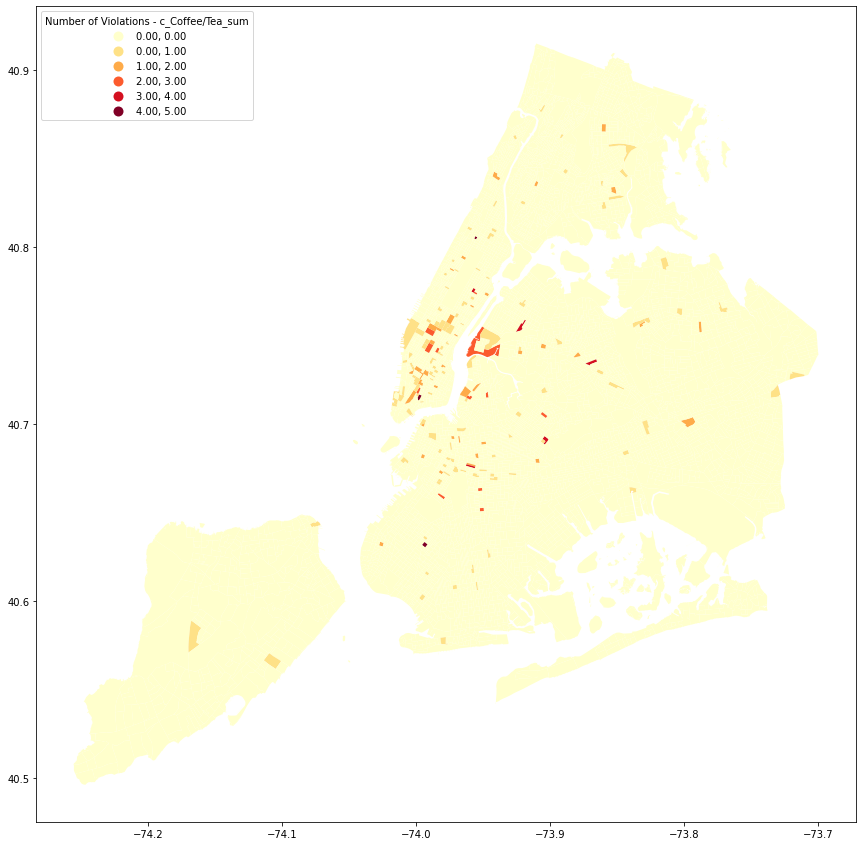

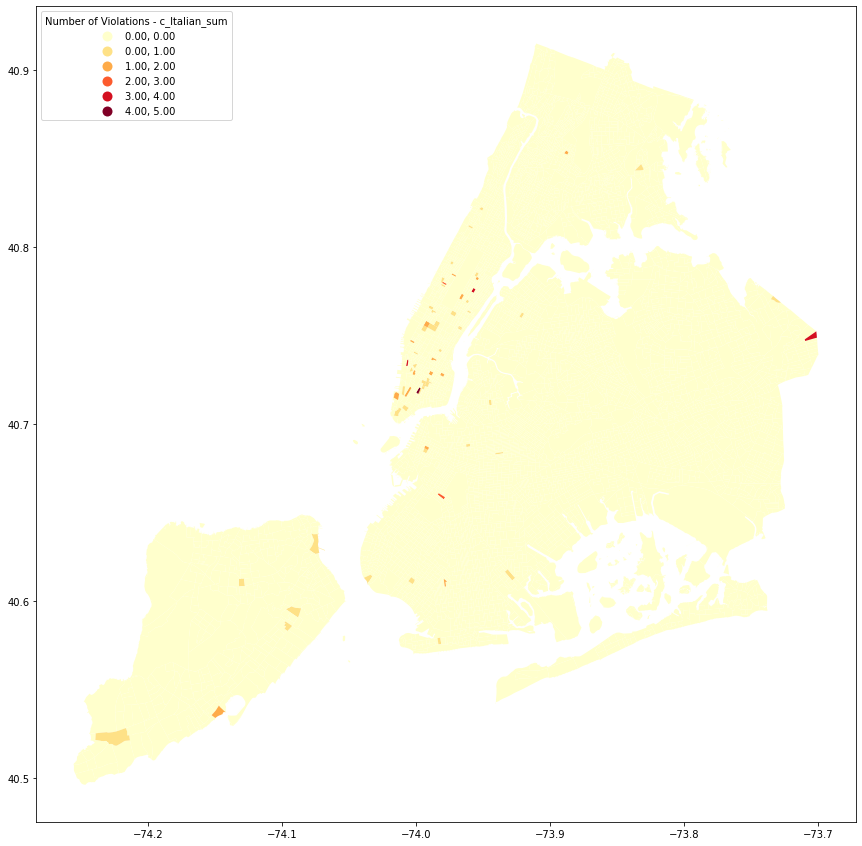

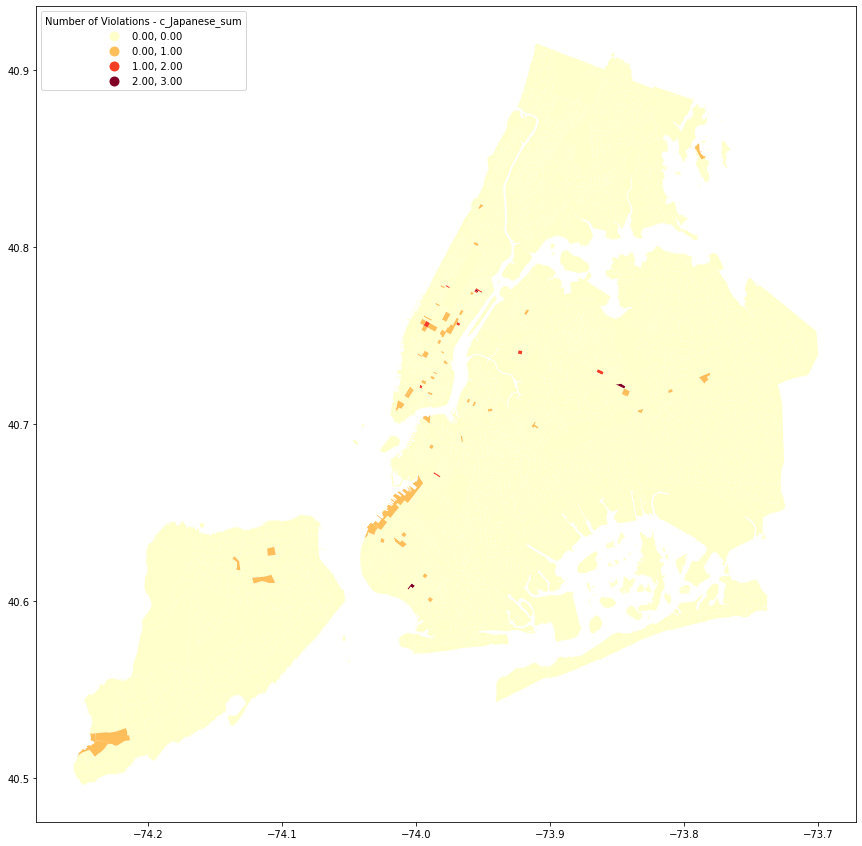

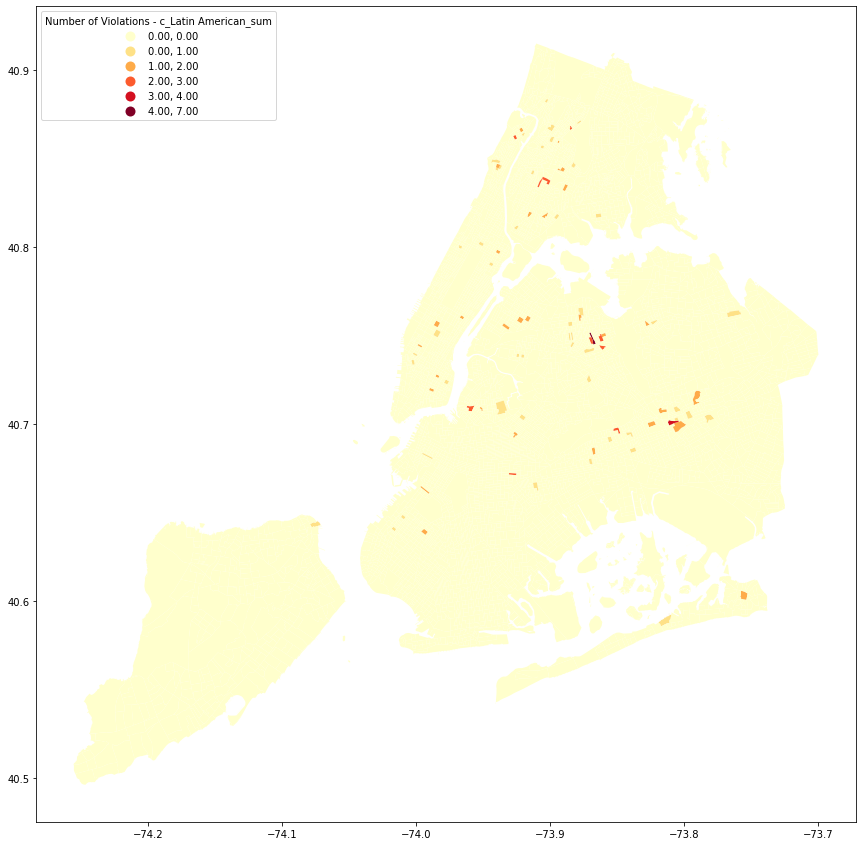

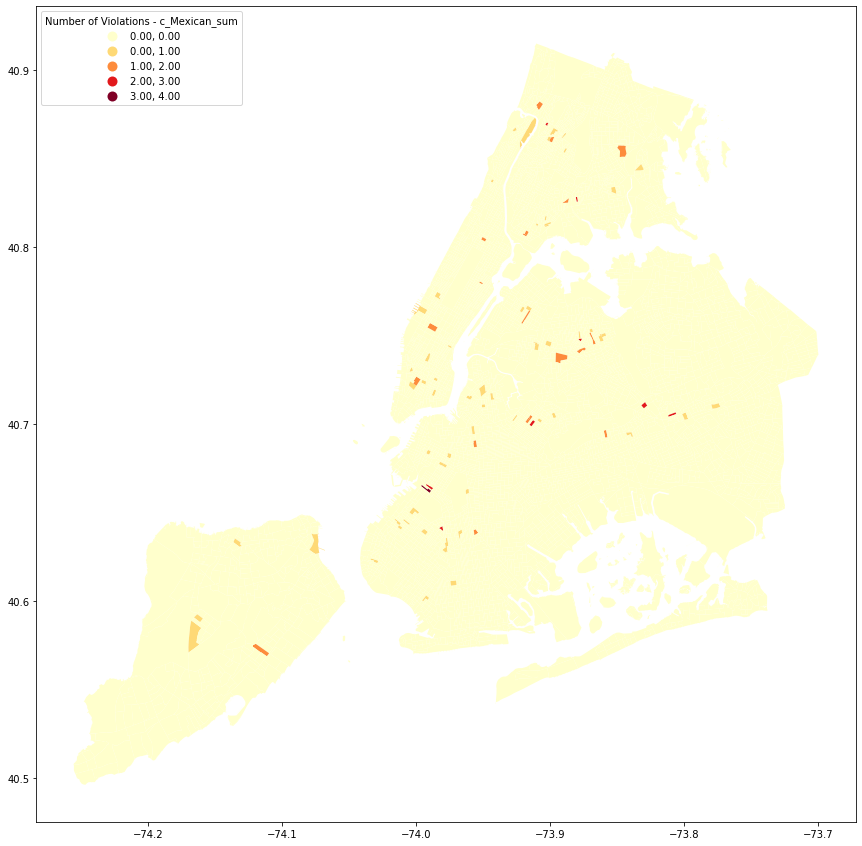

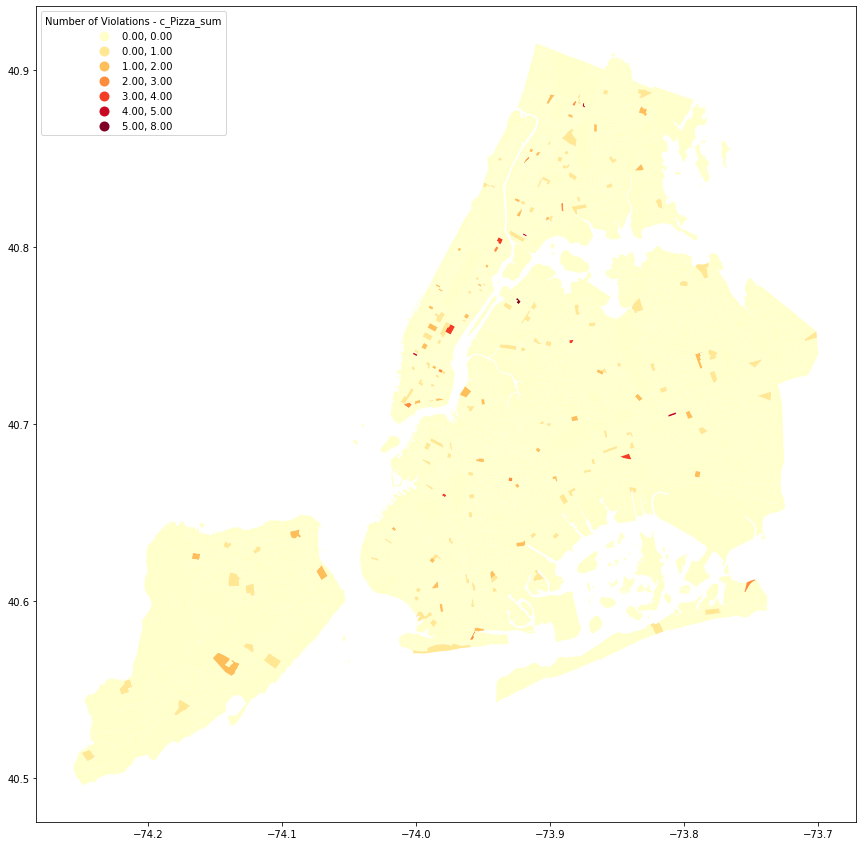

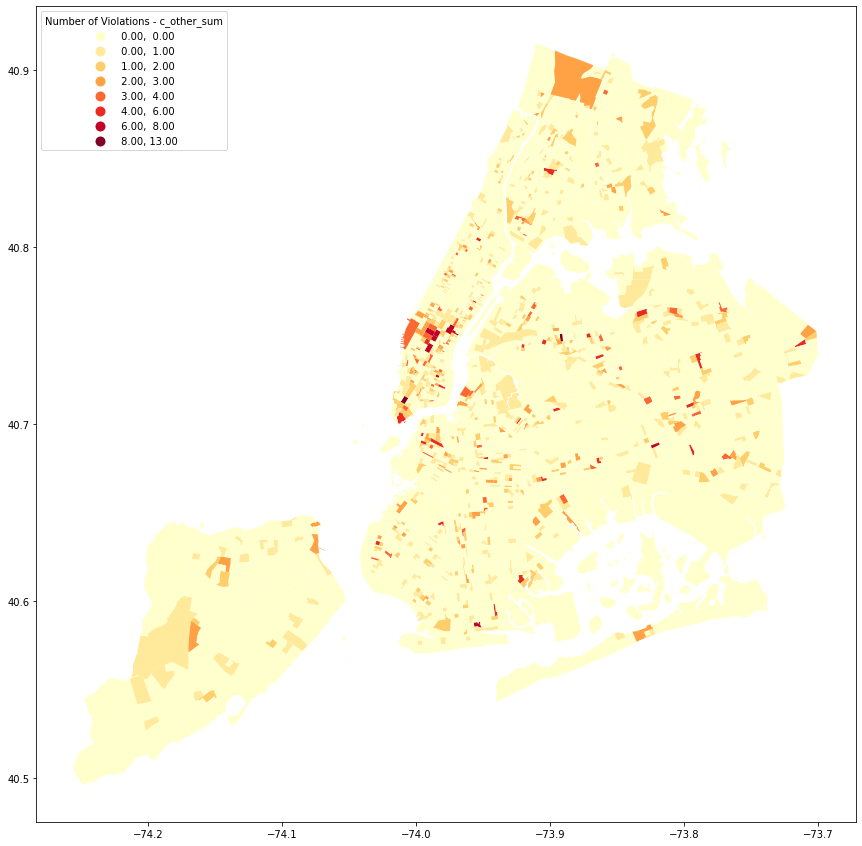

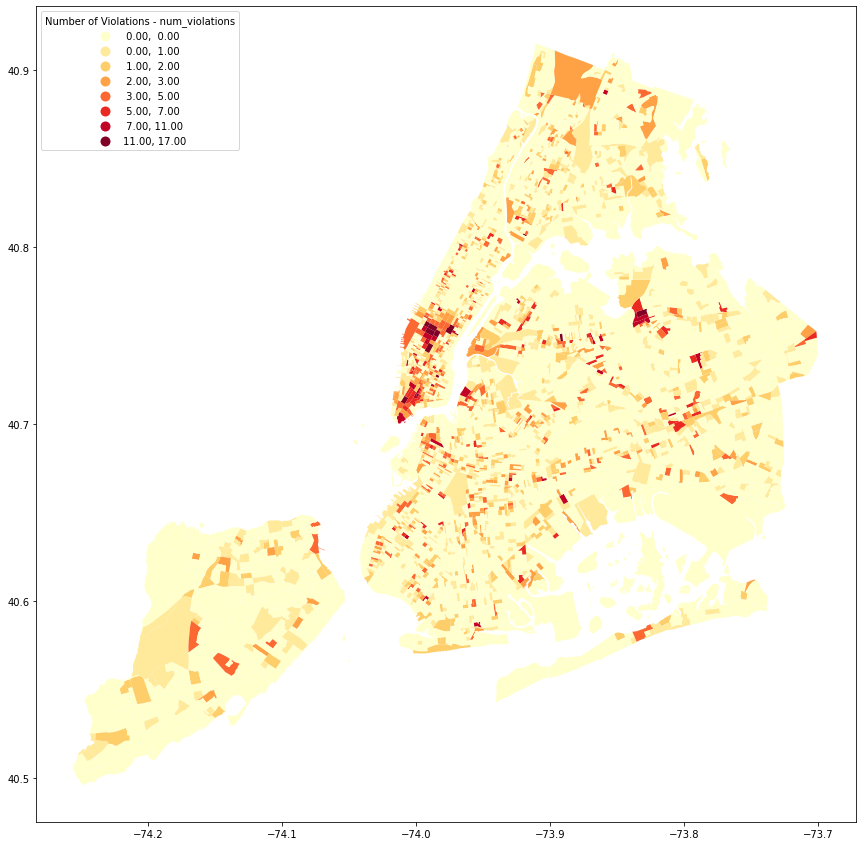

In [87]:
def plot_map(column_name, title):
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    pest_control_slim_gdf.plot(column=column_name,
                        ax=ax,
                        cmap='YlOrRd',
                        scheme='natural_breaks',
                        k=8,
                        legend=True,
                        missing_kwds={'color': 'lightgray'},
                        legend_kwds={'loc': 'upper left', 'title': title})
    plt.show()

for column in column_list:
    plot_title = f'Number of Violations - {column}'
    plot_map(column, plot_title)